In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize,scale,MinMaxScaler
import os
from scipy.linalg import svd
from PIL import Image
from skimage.transform import resize
from mnist import MNIST
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV

### Data Download and Preprocessing

In [3]:
mndata = MNIST('data/mnist')

images, labels = mndata.load_training()
train_images,train_labels = np.array(images),np.array(labels)
images, labels = mndata.load_testing()
test_images,test_labels = np.array(images),np.array(labels)

In [5]:
train_images.shape

(60000, 784)

In [19]:
# ONLY A TRAINING SAMPLE OF 10000 IS USED FOR FASTER PROCESSING
sample_size = 10000
train_images,train_labels = train_images[:sample_size],train_labels[:sample_size]
test_images,test_labels = test_images[:sample_size],test_labels[:sample_size]

In [20]:
# SCALE IMAGE TO THE RANGE OF 0-1, AS THIS IS IMPORTANT FOR REGULARIZATION
scaler = MinMaxScaler()
A_train = scaler.fit_transform(train_images.T).T
A_test = scaler.transform(test_images.T).T

In [21]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(10000, 784)
(10000,)
(10000, 784)
(10000,)


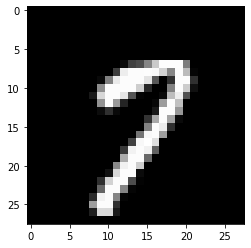

In [22]:
# EXAMPLE IMAGE
plt.imshow(A_train[-1,:].reshape(28,28),cmap=plt.get_cmap('gray'))

In [23]:
# CREATE TRAINING MATRIX B
b_train = np.zeros((train_labels.size, train_labels.max()+1))
b_train[np.arange(train_labels.size),train_labels] = 1
b_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [24]:
# CREATE THE TEST MATRIX B
b_test = np.zeros((test_labels.size, test_labels.max()+1))
b_test[np.arange(test_labels.size),test_labels] = 1
b_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
# Given A,X and b, this function calculates prediction accuracy.
def calculate_accuracy(A,X,b):
    b_hat = np.dot(A,X)
    b_pred = np.argmax(b_hat,axis=1)
    return accuracy_score(b,b_pred)

### Question 1: Using Various Linear Solvers

#### METHOD 1: MULTI TASK LASSO

In [27]:
# MULTI TASK LASSO with alpha=0.1
clf = linear_model.MultiTaskLasso(alpha=0.01,fit_intercept=False)
clf.fit(A_train,b_train)

MultiTaskLasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=1000,
               normalize=False, random_state=None, selection='cyclic',
               tol=0.0001, warm_start=False)

In [28]:
X_train_lasso = clf.coef_.T
X_train_lasso.shape

(784, 10)

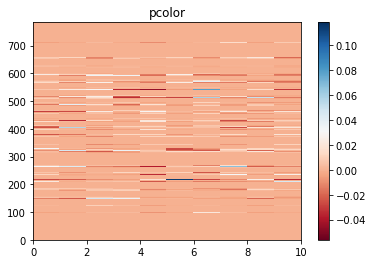

In [29]:
fig, ax = plt.subplots(1, 1)
c = ax.pcolor(X_train_lasso, cmap='RdBu')
ax.set_title('pcolor')
fig.colorbar(c, ax=ax)

#### METHOD 2: NORMAL EQUATIONS

In [26]:
# ORDINARY LEAST SQUARES BY PROJECTING B INTO THE COLUMN SPACE A USING NORMAL EQUATIONS
# X_ols = np.linalg.multi_dot(np.linalg.inv(np.dot(A_train.T,A_train)),A_train.T,B)
# THIS DOESN'T WORK BECAUSE THE MATRIX A_TRANSPOSE*A IS SINGULAR:
# THAT IS BECAUSE THE MATRIX A HAS ALL ZEROS ON THE VERY FIRST PIXEL
np.linalg.cond(np.dot(A_train.T,A_train))
print(max(A_train[:,1]))

0.0


### Question 2:  Ranking the most important pixels

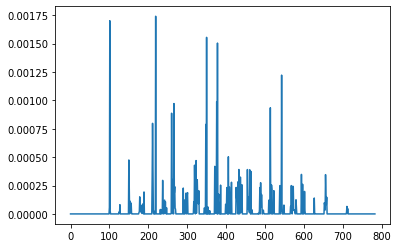

In [30]:
pixel_variation = np.var(X_train_lasso,axis=1)
plt.plot(pixel_variation)

Text(0.5, 1.0, 'Variation vs. Pixel Number')

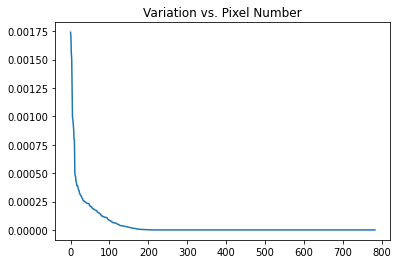

In [31]:
varation_ind_sorted = np.argsort(pixel_variation)[::-1]
fig, ax = plt.subplots(1, 1)
ax.plot(pixel_variation[varation_ind_sorted])
ax.set_title('Variation vs. Pixel Number')

In [33]:
# PIXEL WITH THE GREATEST VARIATION
varation_ind_sorted[0]

219

#### Explanation:
I sorted the cofficients matrix X by the amount of variation in each pixel. This should tell us which pixels are most important. The pixel 219 had the greatest variation

### Question 3:  Number of pixels vs. accuracy

In [35]:
# ACCURACY OF MULTI TASK LASSO IN THE TRAINING DATA
b_train_hat = np.dot(A_train,X_train_lasso)
b_train_pred = np.argmax(b_train_hat,axis=1)
accuracy_score(train_labels,b_train_pred)

0.8215

In [36]:
# ACCURACY IN THE TEST DATA
b_test_hat = np.dot(A_test,X_train_lasso)
b_test_pred = np.argmax(b_test_hat,axis=1)
accuracy_score(test_labels,b_test_pred)

0.8082

In [37]:
# BASELINE SCORE IF WE RANDOMIZE THE TEST LABELS
accuracy_score(test_labels,np.random.choice(test_labels.tolist(),test_labels.shape[0]))

0.1003

In [38]:
# PICK THE PIXELS WITH LARGER AND LARGER AMOUNTS OF VARIATION AND DETERMINE THE ACCURACY
accuracies_train = np.zeros(len(pixel_variation))
accuracies_test = np.zeros(len(pixel_variation))
for i in range(1,len(pixel_variation)+1):
    # PICK THE PIXELS WITH LARGEST VARIATION
    pixel_ind = varation_ind_sorted[:i]
    accuracies_train[i-1] = calculate_accuracy(A_train[:,pixel_ind],
                                          X_train_lasso[pixel_ind,:],train_labels)
    accuracies_test[i-1] = calculate_accuracy(A_test[:,pixel_ind],
                                      X_train_lasso[pixel_ind,:],test_labels)

Text(0.5, 1.0, 'Accuracy vs Number of pixels included')

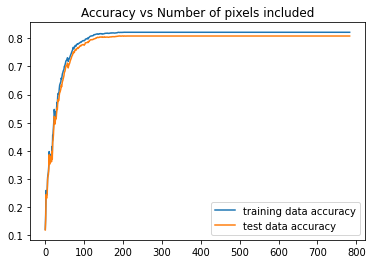

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(accuracies_train,label='training data accuracy')
ax.plot(accuracies_test,label='test data accuracy')
ax.legend()
ax.set_title('Accuracy vs Number of pixels included')

#### Explanation:
We can see that if we include just the pixel with the higest variation, we get about 15% accuracy. As we increase the number of pixels included we can a more and more accurate prediction both in training data and test data. The accuracy in the test data is slightly smaller that in the training data, but this is more or less normal. 

### Question 4:  Important pixels for each digit

In [40]:
def plot_important_coefficients(coefficients,digit):
    fig, ax = plt.subplots(1, 1)
    ax.plot(coefficients)
    ax.set_title(f'IMPORTANT COEFFICIENTS FOR {digit}')

In [41]:
def plot_important_coefficients_image_format(coefficients,digit):
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolor(coefficients.reshape(28,28), cmap='RdBu')
    ax.set_title(f'IMPORTANT COEFFICIENTS FOR {digit}')
    fig.colorbar(c, ax=ax)

/Users/eozkan/.virtualenvs/jpt/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6875852957675868, tolerance: 0.10010000000000001
  positive)
/Users/eozkan/.virtualenvs/jpt/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.686893035875265, tolerance: 0.1032
  positive)
/Users/eozkan/.virtualenvs/jpt/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.814362173875677, tolerance: 0.0944
  positive)
/Users/eozkan/.virtualenvs/jpt/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

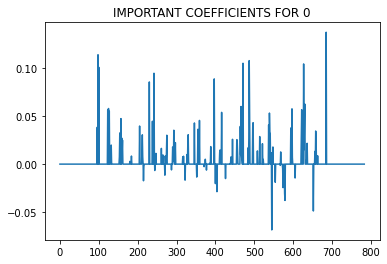

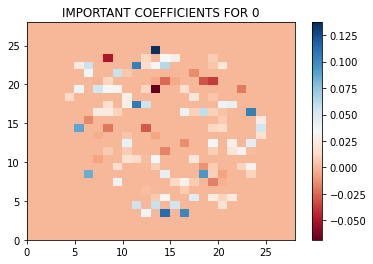

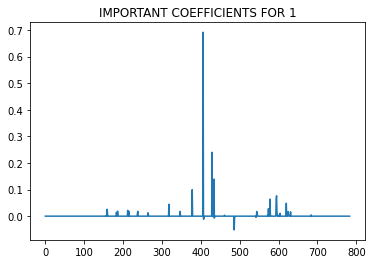

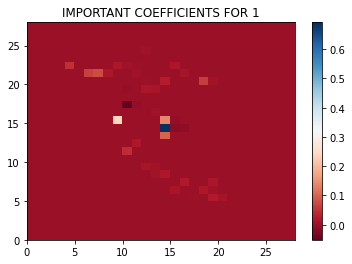

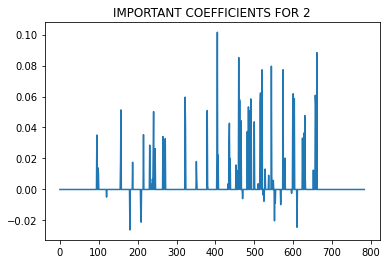

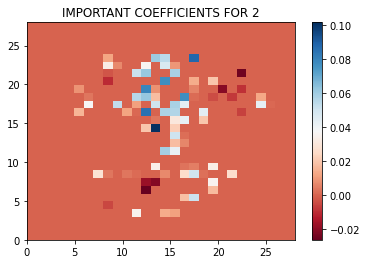

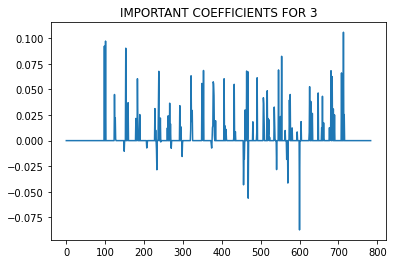

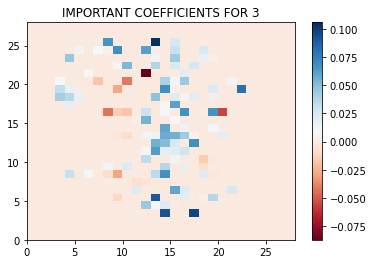

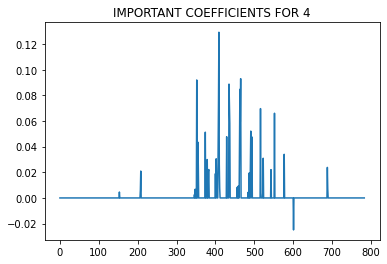

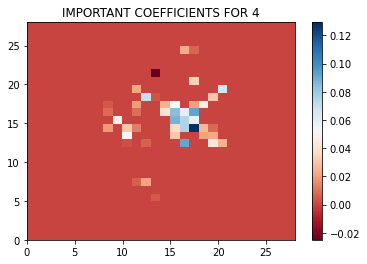

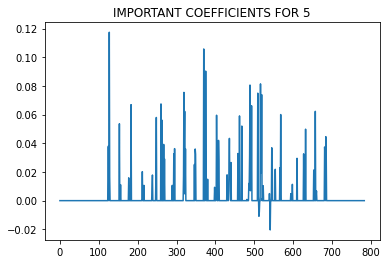

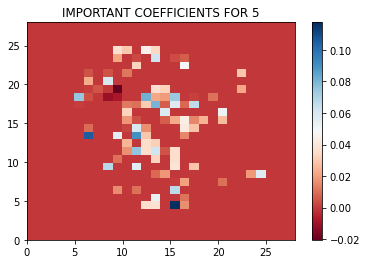

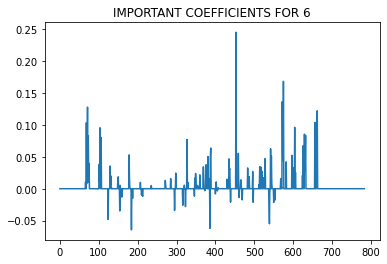

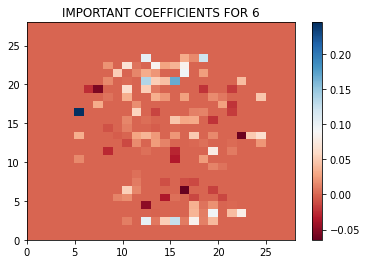

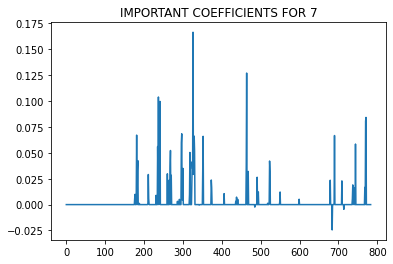

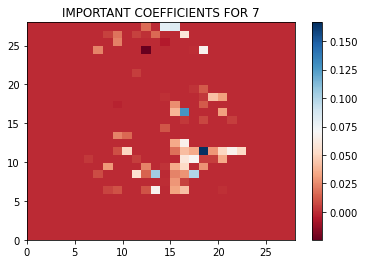

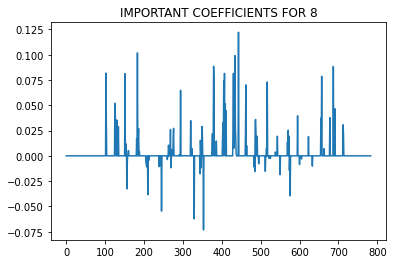

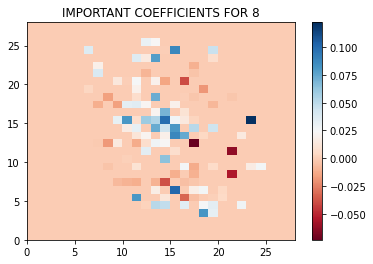

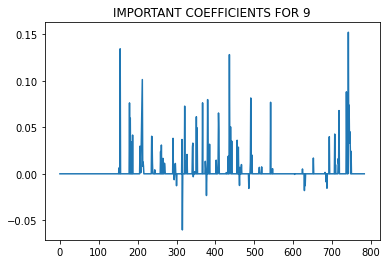

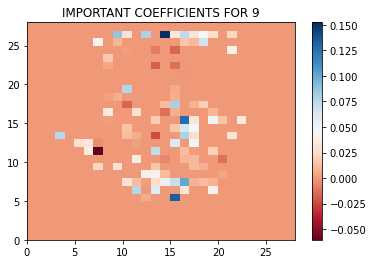

In [42]:
digit_accuracies = []
digit_alphas = []
for digit in range(10):
    # SUBSET DATA TO A PARTICULAR DIGIT
    X = A_train[train_labels==digit]
    y = b_train[train_labels==digit][:,digit]

    # FIT A LASSO MODEL TO FIND THE BEST REGULARIZATION COEFFICIENT ALPHA USING CV
    reg = LassoCV(cv=5,fit_intercept=False).fit(X, y)
    y_hat_train = reg.predict(X)

    # FIND THE BEST THRESHOLD FOR PREDICTION
    max_acc = 0
    threshold = 0.5
    for i in np.arange(min(y_hat_train),max(y_hat_train),0.05):
        threshold_acc = accuracy_score(y,y_hat_train>i)
        threshold = i if threshold_acc>max_acc else threshold
        max_acc = threshold_acc if threshold_acc>max_acc else max_acc

    # MAKE PREDICTION ON TEST DATA
    X_test = A_test[train_labels==digit]
    y_test = b_test[train_labels==digit][:,digit]
    y_hat_test = reg.predict(X_test)
    digit_accuracies.append(accuracy_score(y_test,y_hat_test>threshold))
    digit_alphas.append(reg.alpha_)
    plot_important_coefficients(reg.coef_,digit)
    plot_important_coefficients_image_format(reg.coef_,digit)

Text(0.5, 1.0, 'Digits vs Accuracy')

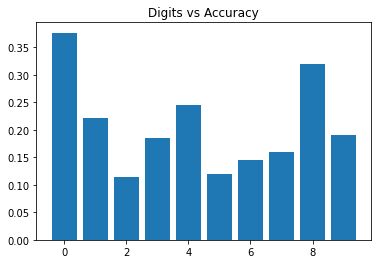

In [43]:
fig, ax = plt.subplots(1, 1)
ax.bar(range(10),digit_accuracies)
ax.set_title('Digits vs Accuracy')

Text(0.5, 1.0, 'Digits vs Regularization parameter alpha')

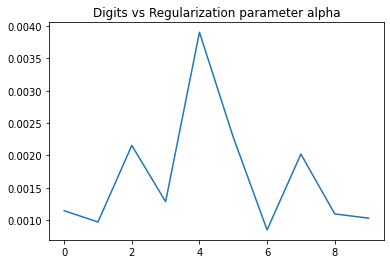

In [44]:
fig, ax = plt.subplots(1, 1)
ax.plot(digit_alphas)
ax.set_title('Digits vs Regularization parameter alpha')

#### Explanation:
In order to pick the most important pixels for each digit we can follow a simpler methodology. We can first optimize the regularization parameter alpha of LASSO to find an alpha that results in best prediction. Then look at which coefficients are non zero. These will tell us the important pixels. Interestingly our overall accuracy was much lower for some of digits such as digit 2.

### Question 5:  Interpretation

A is m by 784 matrix where m is number of images in our dataset. X is 784 by 10a and B is m by 10. When we are trying to find a X such that AX=B is satisfied, we are trying to find a matrix X such that nth column of X is a vector with negative entries where nth digit is most different from other digits and positive entries where nth digit is most similar to other digits.